In [1]:
%matplotlib inline

In [2]:
# -------
# Imports
# -------
import math
import numpy as np
import pandas as pd
import moviepy.editor as mpy
from collections import namedtuple
from matplotlib import cm, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import HTML

point = namedtuple('Point', ['x', 'y'])

In [3]:
print(animation.writers.list())

['ffmpeg', 'ffmpeg_file', 'html']


In [113]:
# ----------
# Grid Setup
# ----------
NDIM = 2

LX = 4
LY = 4
NX = 200
NY = 200
dx = LX / (NX - 1)
dy = LY / (NY - 1)
x = np.linspace(0, 4, NX)
y = np.linspace(0, 4, NY)
X, Y = np.meshgrid(x, y)

dt = 0.01

# -------------------
# Physical Properties
# -------------------
visc  = 1.0
diff  = 1
diss  = 1.0
force = 0

# ------------------
# Initial Conditions
# ------------------

u0 = np.zeros((NY, NX))
u1 = np.zeros((NY, NX))
v0 = np.zeros((NY, NX))
v1 = np.zeros((NY, NX))
source_vel = np.zeros((NY,NX))

s0 = np.zeros((NY, NX))
s1 = np.zeros((NY, NX))
source = np.zeros((NY, NX))

div = np.zeros((NY, NX))
p   = np.zeros((NY, NX))

# u1[int(2 / dy):int(2.6 / dy + 1), int(1 / dx):int(1.3 / dx + 1)] = .01
u0[1:-2, 1:int(3.9 / dx + 1)] = .1
v0[1:-2, 1:int(3.9 / dx + 1)] = .1
u1[1:-2, 1:int(3.9 / dx + 1)] = .11
v1[1:-2, 1:int(3.9 / dx + 1)] = .11
s0[int(1 / dy):int(1.3 / dy + 1), int(1 / dx):int(1.6 / dx + 1)] = 10
s1[int(1 / dy):int(1.6 / dy + 1), int(1 / dx):int(1.6 / dx + 1)] = 10
source[int(2 / dy):int(2.5 / dy + 1), int(2 / dx):int(2.5 / dx + 1)] = 10

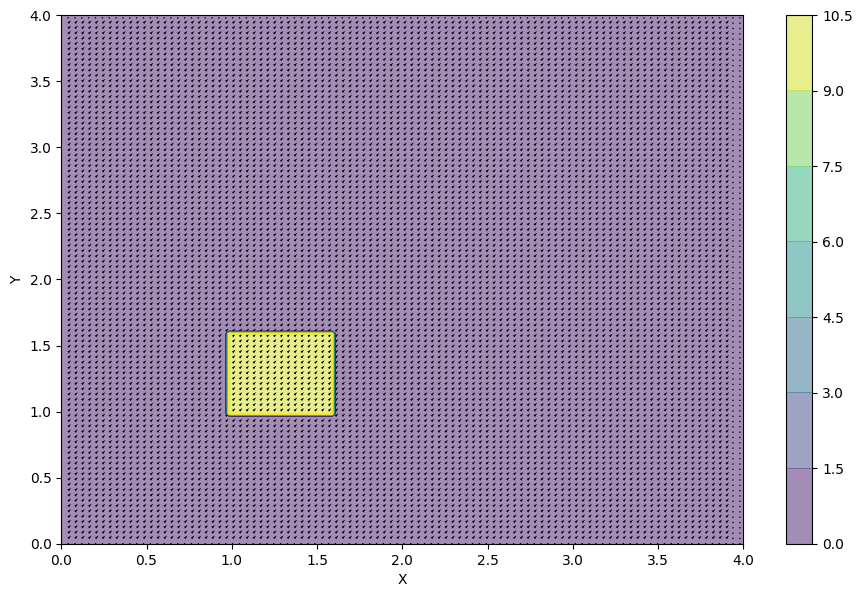

In [114]:
makeplot(s1, u0, v0)

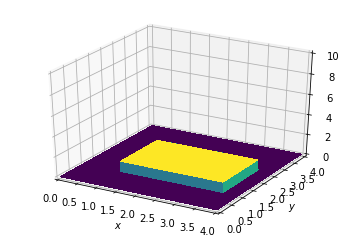

In [84]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(0, LX)
ax.set_ylim(0, LY)
ax.set_zlim(0, 10)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

surfplot = ax.plot_surface(X, Y, s1, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
surf = [surfplot]

In [44]:
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    simulate()
    plot[0] = ax.plot_surface(X, Y, zarray, rstride=1, cstride=1, cmap=cm.viridis,
                             linewidth=0, antialiased=False)

In [45]:
anim = animation.FuncAnimation(fig, update_plot, 80, interval=5, fargs=(s1, surf))
plt.show()

In [46]:
HTML(anim.to_html5_video())

In [ ]:
makeplot(s1, u1, v1)

In [ ]:
# ---------
# Main Loop
# ---------
# def simulate():
for i in range(0,32):
    vel_step(u1, v1, u0, v0, visc, force, dt)
    dens_step(s1, s0, u1, v1, source, diff, diss, dt)
    source[:, :] = 0
    if (i % 8) == 0:
        plotfig(s1) 
        makeplot(s1, u1, v1)

In [7]:
# ------------
# Density Step
# ------------
def dens_step(s1, s0, u, v, source, diff, diss, dt):
    add_source(s1, s0, dt)
    add_source(s1, source, dt)
    s1, s0 = s0, s1
    diffuse(s1, s0, diff, dt)
    s1, s0 = s0, s1
    advect(s1, s0, u, v, dt)
#   dissipate(s1, s0, diss, dt)

In [8]:
# -------------
# Velocity Step
# -------------
def vel_step(u1, v1, u0, v0, visc, force, dt):
    add_source(u1, u0, dt)
    add_source(v1, v0, dt)
    u1, u0 = u0, u1
    diffuse(u1, u0, visc, dt, 'x_vel')
    v1, v0 = v0, v1
    diffuse(v1, v0, visc, dt, 'y_vel')
    project(u1, v1, p, div)
    u1, u0 = u0, u1
    v1, v0 = v0, v1
    advect(u1, u0, u0, v0, dt, 'x_vel')
    advect(v1, v0, u0, v0, dt, 'y_vel')
    project(u1, v1, p, div)

In [59]:
def project(u1, v1, p, div):
    find_divergence(div, u1, v1)
    p[:, :] = 0
    set_boundary(div)
    set_boundary(p)
    
    for _ in range(20):
        p[1:-1, 1:-1] = (div[1:-1, 1:-1] + p[1:-1, 0:-2] + p[1:-1, 2:] + p[0:-2, 1:-1] + p[2:, 1:-1])/4
        set_boundary(p)
    
    u1[1:-1, 1:-1] -= 0.5*dx*(p[1:-1, 2:] - p[1:-1, 0:-2])
    v1[1:-1, 1:-1] -= 0.5*dy*(p[2:, 1:-1] - p[0:-2, 1:-1])
    
    set_boundary(u1, 'x_vel')
    set_boundary(v1, 'y_vel')

In [47]:
# ----------
# Add Source
# ----------
def add_source(q, source, dt):
    q += dt * source

In [11]:
# ---------------
# Diffuse Density
# ---------------
def diffuse(q1, q0, diff, dt, boundary=''):
    a = dt * diff * np.size(q0)

    for _ in range(20):
        q1[1:-1, 1:-1] = (q0[1:-1, 1:-1] + a * (q1[1:-1, 0:-2] + q1[1:-1, 2:] + q1[0:-2, 1:-1] + q1[2:, 1:-1])) / (1 + 4 * a)
        set_boundary(q1, boundary)

In [12]:
# --------------
# Advect Density
# --------------
def advect(q1, q0, u, v, dt, boundary=''):
    dt0 = -dt * NX

    for i in range(1, NX-1):
        for j in range(1, NY-1):
            orig_pos = point(i * dx, j * dy)
            orig_vel = point(u[j, i], v[j, i])

            # RK2
            half_dt = 0.5 * dt0
            halfway_pos_x = orig_pos.x + half_dt * orig_vel.x
            halfway_pos_y = orig_pos.y + half_dt * orig_vel.y

            # Restrict pos values if boundary doesn't wrap around
            halfway_pos = point(clamp_pos(halfway_pos_x, 0, LX), \
                                clamp_pos(halfway_pos_y, 0, LY))
            
            halfway_vel = point(interpolate(u, halfway_pos), \
                                interpolate(v, halfway_pos))
            
            backtrack_pos_x = orig_pos.x + dt0 * halfway_vel.x
            backtrack_pos_y = orig_pos.y + dt0 * halfway_vel.y
            
            # Restrict pos values if boundary doesn't wrap around
            backtrack_pos = point(clamp_pos(backtrack_pos_x, 0, LX), \
                                  clamp_pos(backtrack_pos_y, 0, LY))

            traced_q = interpolate(q0, backtrack_pos)
            q1[j, i] = traced_q
    
    set_boundary(q1, boundary)

In [13]:
# ----------------
# Helper Functions
# ----------------

def interpolate(x, pos):
    i0 = int(pos.x / dx)
    j0 = int(pos.y / dy)
    i1 = int(clamp_pos(i0 + 1, 0, NX - 1))
    j1 = int(clamp_pos(j0 + 1, 0, NY - 1))

    it = abs(pos.x - i0 * dx)
    jt = abs(pos.y - j0 * dy)
    
    # print(i0, j0, i1, j1, it, jt)

    assert (it < 1.0 and it >= 0)
    assert (jt < 1.0 and jt >= 0)

    try:
        xBottomLeft   = x[j1, i0]
        xBottomRight  = x[j1, i1] 
        xBottomInterp = lerp(xBottomLeft, xBottomRight, it)
    except:
        print(pos)

    xTopLeft   = x[j0, i0]
    xTopRight  = x[j0, i1]
    xTopInterp = lerp(xTopLeft, xTopRight, it)

    xMidInterp = lerp(xBottomInterp, xTopInterp, jt)
    
    return xMidInterp


def set_boundary(x, boundary=''):
    x[0, 1:-1] = -x[1,  1:-1] if boundary == 'y_vel' else x[1,  1:-1]
    x[-1,1:-1] = -x[-2, 1:-1] if boundary == 'y_vel' else x[-2, 1:-1]
    x[1:-1, 0] = -x[1:-1,  1] if boundary == 'x_vel' else x[1:-1,  1]
    x[1:-1,-1] = -x[1:-1, -2] if boundary == 'x_vel' else x[1:-1, -2]
    
    x[0,   0] = 0.5 * (x[1, 0]   + x[0, 1])
    x[0,  -1] = 0.5 * (x[1, -1]  + x[0, -2])
    x[-1,  0] = 0.5 * (x[-2, 0]  + x[-1, 1])
    x[-1, -1] = 0.5 * (x[-2, -1] + x[-1, -2])
    
    
def clamp_pos(pos, minval, maxval):
    """
    Clamp position coordinate acording to min and max limits.

    Parameters
    ----------
    pos : float
        Position coordinate.
    minval : float
        Minimum value allowed.
    maxval : float
        Maximum value allowed.

    Returns
    -------
    float
        Clamped position coordinate.
    """
    return maxval if pos > maxval else minval if pos < minval else pos


def lerp(v0, v1, t):
    return (1 - t) * v0 + t * v1


def find_divergence(div, u, v):
    div[1:-1, 1:-1] = (u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy)

In [14]:
def plotfig(q):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, q, rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0, LX)
    ax.set_ylim(0, LY)
    ax.set_zlim(0, 10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$');

In [15]:
def makeplot(s, u, v):
    fig = plt.figure(figsize=(11,7), dpi=100)
    # plotting the pressure field as a contour
    plt.contourf(X, Y, s, alpha=0.5, cmap=cm.viridis)  
    plt.colorbar()
    # plotting the pressure field outlines
    plt.contour(X, Y, s, cmap=cm.viridis)  
    # plotting velocity field
    plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
    plt.xlabel('X')
    plt.ylabel('Y')

In [ ]:
# ------
# Tests
# ------

NX = 8
NY = 8
dx = 1
dy = 1

sourcex = np.zeros((NY,NX))
x0 = np.zeros((NY,NX))
x1 = np.zeros((NY,NX))
u1 = np.zeros((NY,NX))
v1 = np.zeros((NY,NX))
div = np.zeros((NY,NX))

for i in range(1,NX-1):
    for j in range(1,NY-1):
        u1[j,i] = i*j
        v1[j,i] = i+j
        

x1[4:6, 1:3] = 10.5
x0[4:6, 1:3] = 10.5
sourcex[4:6, 1:3] = 10.5

deltat = 0.01
diff = 20

In [ ]:
print(u1,"\n\n",v1)
find_divergence(div, u1, v1)
print("\n",div)

In [ ]:
print(x1)
print(x0)
for i in range(10):
    add_source(x1, x0, deltat)
    add_source(x1, sourcex, deltat)
    x1, x0 = x0, x1
    diffuse(x1, x0, diff, dt)
    x1, x0 = x0, x1
    advect(x1, x0, u1, v1, deltat)
print("\n")
print(x1)
print("\n")
print(x0)

In [ ]:
# ---------------
# Diffuse Density 2
# ---------------
# def diffuse2(s0, s1, diff, dt):
#     a = dt * diff * np.size(s0)

#     for _ in range(20):
#         for i in range(1, NX-1):
#             for j in range(1, NY-1):
#                 s1[i, j] = (s0[i, j] + a * (s1[i-1, j] + s1[i+1, j] + s1[i, j-1] + s1[i, j+1])) / (1 + 4 * a)
#                 # print("s1[" + repr(i) + "," + repr(j) + "] = " + repr(s1[i,j]))
#         set_boundary(s1)


## Animation

# img = np.ones((3, NY, NX), dtype = float)
# img[:, :, :] = s1
# coefs = np.array([2,25,25]).reshape((3,1,1))
# img = 255*coefs*img

# def make_frame(t):
#     for i in range(0, NX):
#         for j in range(0, NY):
#             if(s1[j,i] > 0):
#                 img[:, j, i] = [math.floor(255 - 42.5 * s1[j,i]*1000), math.floor(255 - 42.5 * s1[j,i])*1000, 0]
#     simulate() 
#     final_image = img[::-1].swapaxes(0,2).swapaxes(0,1)
#     return np.minimum(255, final_image)
# animation = mpy.VideoClip(make_frame, duration=2)
# animation.write_videofile('test.mp4', fps=4)